# Ibis demo

Ibisはpandasの作者[Wes](https://github.com/wesm)が作ったライブラリです。
pandasと大規模データをつなぐ橋渡しをします。

pandasだとメモリに載せた処理が必須でしたが、Ibisは裏側にSQLエンジンを使うことで、大規模データをあたかもDataFrameを扱うようにプログラマブルにpandas likeな処理ができます。

今回のデモでは、IbisとImpalaを組み合わせてデータの傾向を可視化して確認しながら、機械学習のモデルを作ります。

In [1]:
import ibis
import os
ibis.options.interactive = True

In [2]:
# Connection
host = os.environ.get('REDSHIFT_HOST', 'localhost')
user = os.environ.get('REDSHIFT_USER')
password = os.environ.get('REDSHIFT_PASS')
con = ibis.postgres.connect(host=host, user=user, port=5439,
                                       password=password,
                                       database='testdb')

# MovieLens 20Mを対象に、映画の好みを機械学習で予測する

レコメンデーションの実験でよく利用される、[Movie Lens](http://grouplens.org/datasets/movielens/)というデータセットを使って映画の好みを予測するモデルを学習する。

- タグデータ、評価データ、映画データの説明
- 評価データの傾向の確認
- 特定のユーザの好みを予測するモデルを[scikit-learn](http://scikit-learn.org/)で学習する

## データの情報
今回は20Mのデータを利用する。  

> Stable benchmark dataset. 20 million ratings and 465,000 tag applications applied to 27,000 movies by 138,000 users. Released 4/2015.

2千万件の映画の評価データが含まれる。  

予め作ってS3に置いた、parquet形式のテーブルを利用している。

### タグデータ

ユーザID、映画ID、ユーザーが付与した映画のタグ、付与した日時(Unixtime)が含まれる。

In [3]:
tags = con.table('tags')

tags.limit(10).execute()

,userid,movieid,tag_name,unixtime
0,65,208,dark hero,1368150078
1,65,521,noir thriller,1368149983
2,65,668,bollywood,1368149876
3,65,1248,noir thriller,1368149983
4,65,1617,neo-noir,1368150217
5,65,1783,noir thriller,1368149983
6,65,2193,dragon,1368151314
7,65,2662,mars,1368150055
8,65,2840,jesus,1368149925
9,65,5135,bollywood,1368149876


### 評価データ

ユーザID、映画ID、評価値（0-5で0.5刻み）、付与した日時(Unixtime)が含まれる。

In [4]:
ratings = con.table('ratings')
ratings

      userid  movieid  rating    unixtime
0          1       29     3.5  1112484676
1          1       47     3.5  1112484727
2          1      112     3.5  1094785740
3          1      223     4.0  1112485573
4          1      260     4.0  1112484826
5          1      296     4.0  1112484767
6          1      337     3.5  1094785709
7          1      541     4.0  1112484603
8          1      593     3.5  1112484661
9          1      919     3.5  1094785621
10         1     1009     3.5  1112486013
11         1     1079     4.0  1094785665
12         1     1089     3.5  1112484669
13         1     1097     4.0  1112485701
14         1     1193     3.5  1112484690
15         1     1198     4.5  1112484624
16         1     1201     3.0  1112484642
17         1     1214     4.0  1094785977
18         1     1217     3.5  1112484810
19         1     1222     3.5  1112484637
20         1     1243     3.0  1112485567
21         1     1249     4.0  1112485382
22         1     1259     4.0  111

### Unixtimeをdatetime型に変換する

元データはUnixtime (int)で格納されているので、年ごとに分析できるようにdatetime型に変換する。

In [5]:
# not exist `to_timestamp(integer)`
expr = ratings.unixtime.cast('timestamp')
ratings2 = ratings['userid', 'movieid', 'rating', expr.name('datetime') ]
ratings2

ProgrammingError: (psycopg2.ProgrammingError) function to_timestamp(integer) does not exist
HINT:  No function matches the given name and argument types. You may need to add explicit type casts.
 [SQL: 'SELECT t0.userid, t0.movieid, t0.rating, timezone(%(timezone_1)s, to_timestamp(t0.unixtime)) AS datetime \nFROM ratings AS t0 \n LIMIT %(param_1)s'] [parameters: {'timezone_1': 'UTC', 'param_1': 10000}]

### 映画データ
映画ID、映画名、ジャンル（`|`区切り）が含まれる

In [6]:
movies = con.table('movies')
movies.columns

['movieid', 'title', 'genres']

In [7]:
movies.execute()

,movieid,title,genres
0,2,Jumanji (1995),Adventure|Children|Fantasy
1,4,Waiting to Exhale (1995),Comedy|Drama|Romance
2,6,Heat (1995),Action|Crime|Thriller
3,8,Tom and Huck (1995),Adventure|Children
4,10,GoldenEye (1995),Action|Adventure|Thriller
5,12,Dracula: Dead and Loving It (1995),Comedy|Horror
6,14,Nixon (1995),Drama
7,16,Casino (1995),Crime|Drama
8,18,Four Rooms (1995),Comedy
9,20,Money Train (1995),Action|Comedy|Crime|Drama|Thriller


### 映画データと評価データをjoinする

In [8]:
joined = ratings.join(movies, ['movieid'])[ratings, movies['title']]
print(ibis.postgres.compile(joined))
print(joined.materialize().columns)
joined.count()

SELECT t0.userid, t0.movieid, t0.rating, t0.unixtime, t1.title 
FROM ratings AS t0 JOIN movies AS t1 ON t0.movieid = t1.movieid
['userid', 'movieid', 'rating', 'unixtime', 'title']


20000263

### 評価データの日付をdatetime型に変えてjoinする

クエリは複雑だけど、Impalaの実行計画は上とかわらない

In [ ]:
expr = ratings.unixtime.cast('timestamp')
ratings2 = ratings['userid', 'movieid', 'rating', expr.name('datetime') ]
joined2 = ratings2.join(movies, ['movieid'])[ratings2, movies['title']]
print(ibis.postgres.compile(joined2))
joined2.count()

In [11]:
df2 = joined.materialize().limit(1000).execute()
df2

,userid,movieid,rating,unixtime,title
0,1,2,3.5,1112486027,Jumanji (1995)
1,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
2,1,50,3.5,1112484580,"Usual Suspects, The (1995)"
3,1,151,4.0,1094785734,Rob Roy (1995)
4,1,253,4.0,1112484940,Interview with the Vampire: The Vampire Chroni...
5,1,293,4.0,1112484703,Léon: The Professional (a.k.a. The Professiona...
6,1,318,4.0,1112484798,"Shawshank Redemption, The (1994)"
7,1,367,3.5,1112485980,"Mask, The (1994)"
8,1,589,3.5,1112485557,Terminator 2: Judgment Day (1991)
9,1,653,3.0,1094785691,Dragonheart (1996)


### 評価値毎に集計をする

In [12]:
rating_hist = ratings.group_by(ratings.rating).aggregate(total=ratings.count())
rating_hist

   rating    total
0     3.5  2200156
1     4.0  5561926
2     3.0  4291193
3     4.5  1534824
4     2.0  1430997
5     0.5   239125
6     2.5   883398
7     1.5   279252
8     5.0  2898660
9     1.0   680732

In [13]:
df = rating_hist.execute()
df

,rating,total
0,3.5,2200156
1,4.0,5561926
2,3.0,4291193
3,4.5,1534824
4,2.0,1430997
5,0.5,239125
6,2.5,883398
7,1.5,279252
8,5.0,2898660
9,1.0,680732


集計の結果、3点,4点に集中していることがわかる。

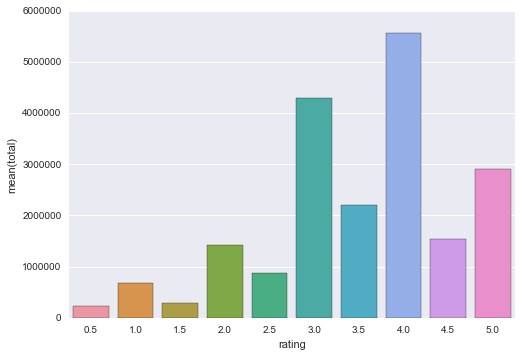

In [14]:
%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x='rating', y='total', data=df)

### 特定の点数より大きいデータの数を数える

In [15]:
ratings.filter([ratings.rating > 4.0]).count()

4433484

In [16]:
ratings.filter([ratings.rating > 3.0]).count()

12195566

### 特定の日付以前/以降のデータの数を数える

- 2015/1/1より後のレビューデータ
- 2015/1/1より前のレビューデータ

の件数をカウントする

In [17]:
from datetime import datetime
import time

def dt2ut(dt):
    return int(time.mktime(dt.timetuple()))
target_timestamp = dt2ut(datetime(2015, 1, 1))
expr = joined.filter([joined.unixtime > target_timestamp]).count()
print(ibis.postgres.compile(expr))
expr

SELECT count(%(param_1)s) AS count 
FROM (SELECT t1.userid AS userid, t1.movieid AS movieid, t1.rating AS rating, t1.unixtime AS unixtime, t2.title AS title 
FROM ratings AS t1 JOIN movies AS t2 ON t1.movieid = t2.movieid 
WHERE t1.unixtime > %(param_2)s) AS t0


284772

In [18]:
joined.filter([joined.unixtime < target_timestamp]).count()

19715491

### 年ごとのレビュー件数を集計する

In [ ]:
joined_hist = joined2.group_by(joined2.datetime.year()).aggregate(total=joined2.count())
joined_hist.sort_by(joined_hist.year)

In [ ]:
sns.barplot(x='year', y='total', data=joined_hist.execute())

### レビュー数が多い top 20 ユーザを抽出する

In [21]:
joined.group_by(joined.userid). \
aggregate(count=joined.count()).sort_by(('count', False)).limit(20)

    userid  count
0   118205   9254
1     8405   7515
2    82418   5646
3   121535   5520
4   125794   5491
5    74142   5447
6    34576   5356
7   131904   5330
8    83090   5169
9    59477   4988
10  130767   4785
11   79159   4707
12    8963   4524
13   15617   4354
14   92011   4236
15   71975   4182
16   20132   4101
17   46470   4094
18   88820   4093
19   63147   3958

### 件数が多いタグ top 20を抽出する

In [22]:
tags.tag_name.value_counts().sort_by(('count', False)).limit(20)

              tag_name  count
0               sci-fi   3384
1      based on a book   3281
2          atmospheric   2917
3               comedy   2779
4               action   2657
5              surreal   2427
6                 BD-R   2334
7         twist ending   2323
8                funny   2072
9             dystopia   1991
10            stylized   1941
11              quirky   1906
12         dark comedy   1899
13             classic   1769
14          psychology   1754
15             fantasy   1703
16         time travel   1549
17             romance   1534
18  visually appealing   1509
19          disturbing   1487

### レビューが一番多いユーザの年ごとの評価件数を調べる

ただし、2001年の評価が圧倒的に多いので除外する。  

In [23]:
# joined3 = joined2.filter([joined2.userid == 118205])
joined3 = joined2.filter([joined2.userid == 118205, joined2.datetime.year() > 2001])
print(ibis.postgres.compile(joined3))
top_user_year_counts = joined3.group_by(joined3.datetime.year()).aggregate(total=joined3.count())
print('-----------------------------\n\n-----------------------------')
print(ibis.postgres.compile(top_user_year_counts))
sns.barplot(x='year', y='total', data=top_user_year_counts.execute())

NameError: name 'joined2' is not defined

### topユーザの評価の傾向から映画と評価点の分割点を調べる

今回は過去の評価データから未来の評価データを予測する。  
そのために、バランスよくpositive/negativeデータに分かれる点数を調べる。  
何点以上を好みとするかを決める。

In [ ]:
top_user_ratings = ratings.filter([ratings.userid == 118205])[ratings.movieid, ratings.rating, ratings.unixtime.cast('timestamp').year()]
top_user_ratings

点数データの分布から、今回は3.5点以上を好みとする。  
なお、2008年以前のデータで学習、2009年以降のデータで評価をする。

In [ ]:
top_user_rating_df = top_user_ratings[top_user_ratings.rating, top_user_ratings.year].execute()
sns.jointplot(x='rating', y='year', data=top_user_rating_df)

### 特徴量を抽出する

通常、レコメンデーションでは協調フィルタリングをすることが多いが、今回は1人のユーザのモデルベースの推薦をするので、映画に付与されたタグのテキスト情報をもとに特徴量を抽出する。  
つまり、テキスト分類の問題として考える。  

まず、各ユーザが付与したタグ情報を、映画ID毎に集約する

In [26]:
# `array_agg` does not exist
movie_tags = tags.group_by(tags.movieid).aggregate(tag_name=tags.tag_name.group_concat(', ').lower()).limit(100000)
movie_tags.execute()

ProgrammingError: (psycopg2.ProgrammingError) function array_agg(character varying) does not exist
HINT:  No function matches the given name and argument types. You may need to add explicit type casts.
 [SQL: 'SELECT t0.movieid, lower(array_to_string(array_agg(t0.tag_name), %(param_1)s)) AS tag_name \nFROM tags AS t0 GROUP BY t0.movieid \n LIMIT %(param_2)s'] [parameters: {'param_1': ', ', 'param_2': 100000}]

### タグ情報のうち、目的のユーザがみた映画に絞り込む

`.isin`を使うと`WHERE...IN`句が使える

In [ ]:
expr = movie_tags[movie_tags.movieid.isin(top_user_ratings.filter([top_user_ratings.rating >= 3.5, top_user_ratings.year.between(2002, 2008)]).movieid)]
print(ibis.postgres.compile(expr))
expr

In [ ]:
# データの偏りを考慮して、3.5以上をpositive, 未満をnegativeとする
old_pos_tags = movie_tags[movie_tags.movieid.isin(top_user_ratings.filter([top_user_ratings.rating >= 3.5, top_user_ratings.year.between(2002, 2008)]).movieid)].tag.execute()
old_neg_tags = movie_tags[movie_tags.movieid.isin(top_user_ratings.filter([top_user_ratings.rating < 3.5, top_user_ratings.year.between(2002, 2008)]).movieid)].tag.execute()
new_pos_tags = movie_tags[movie_tags.movieid.isin(top_user_ratings.filter([top_user_ratings.rating >= 3.5, top_user_ratings.year > 2008]).movieid)].tag.execute()
new_neg_tags = movie_tags[movie_tags.movieid.isin(top_user_ratings.filter([top_user_ratings.rating < 3.5, top_user_ratings.year > 2008]).movieid)].tag.execute()

In [ ]:
# 好きな映画を`1`、嫌いな映画を`-1`として、正解ラベルデータを作る
import pandas as pd

old_tag_labels = [1] * len(old_pos_tags) + [-1] * len(old_neg_tags)
new_tag_labels = [1] * len(new_pos_tags) + [-1] * len(new_neg_tags)

old_tags = pd.concat([old_pos_tags, old_neg_tags], ignore_index=True)
new_tags = pd.concat([new_pos_tags, new_neg_tags], ignore_index=True)

### scikit-learnでロジスティック回帰を使って学習する

`CountVectorizer`を使うことで、テキストの頻度ベースのベクトルを作れる。  
今回は、Bag of Wordsで特徴ベクトルを作成する。

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ('vect', CountVectorizer(binary=True)),
        ('clf', LogisticRegression(random_state=42))
    ])
clf.fit(old_tags, old_tag_labels)

In [ ]:
# 新しい映画の1つ目（positive = 1）を予測
clf.predict([new_tags.iloc[0]])

In [ ]:
# 新しい映画の最後（negative = -1）を予測
clf.predict([new_tags.iloc[-1]])

In [ ]:
from sklearn.metrics import classification_report, f1_score

new_pred_labels = clf.predict(new_tags)
print(classification_report(new_tag_labels, new_pred_labels))
f1_score(new_tag_labels, new_pred_labels)

### scikit-learnで線形SVMを使って学習する

アルゴリズムをSVMを使って学習する。その際に、`GridSearchCV`を使ってパラメータ探索をする。

In [ ]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

pl2 = Pipeline([
        ('vect', CountVectorizer(binary=True)),
        ('clf', SVC(kernel='linear', random_state=42))
    ])
param_grid = dict(clf__C=[0.01, 0.1, 1, 10])

clf = GridSearchCV(pl2, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
clf.fit(old_tags, old_tag_labels)

print("\n+ Best parameters:\n")
print(clf.best_estimator_)

print("\n+ Average score with CV of traning data set:\n")
for params, mean_score, all_scores in clf.grid_scores_:
    print("{:.3f} (+/- {:.3f}) for {}".format(mean_score, all_scores.std() / 2, params))

print("\n+ Predict report of test data set:\n")
y_true, y_pred = new_tag_labels, clf.predict(new_tags)
print(classification_report(y_true, y_pred))

### Furture works

[spark-sklearn](https://github.com/databricks/spark-sklearn)を使うことで、`GridSearchCV`を使ったパラメータ探索をsparkで分散して行える。  
なおspark-sklearnには、`LogisticRegression`と`LinearRegression`はSparkのRDDに変換するメソッドがある。